In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors, ensemble, svm, metrics
from imblearn.under_sampling import CondensedNearestNeighbour
import copy

### Составляем различные таблицы

In [2]:
dau = pd.read_csv('practice_dau_and.csv', sep='|')
pact = pd.read_csv('practice_pact_and.csv', sep='|')
print('Loaded')

Loaded


Таблица "платящих" игроков:

In [4]:
pay_players = pact[pact.transactions > 0].reset_index()
pay_players = pay_players.drop(['index'], axis='columns')
pay_players.to_csv('pay_players_pact.csv', sep='|')
pay_players = pay_players.groupby(['id'], as_index=False).count()
pay_players = pay_players.drop(['actdate', 'regdate', 'clusters', 
                                'revenue', 'transactions', 'quest',
                                'm_quests', 'crystals', 'store_enters'], axis='columns')
#print(pay_players)
pay_players.to_csv('pay_players.csv')

In [6]:
dau2 = pd.merge(pay_players, dau, on=['id'], how='left')
dau_pact = pd.merge(dau2, pact, on=['id', 'actdate'], how='left')
#print(dau_pact)
dau_pact.to_csv('pay_players_dau_pact.csv')

Таблица активных игроков:

In [5]:
pact['day_n'] = (pd.to_datetime(pact['actdate']) - 
                 pd.to_datetime(pact['regdate'])).dt.days
active_players = pact[pact.day_n < 31 + 14].reset_index()
print('Done 1')
active_players = active_players[pd.to_datetime(active_players.regdate) < pd.to_datetime('2017-04-15')].reset_index()
print('Done 2')
active_players = active_players.pivot_table(values='actdate', columns=['day_n'], index=['id'], aggfunc='count')
active_players['w3_played'] = active_players[[17.0, 18, 19, 20, 21, 22, 23]].count(1)
active_players['w4_played'] = active_players[[24.0, 25, 26, 27, 28, 29, 30]].count(1)
active_players = active_players[active_players['w3_played'] + active_players['w4_played'] > 0]
active_players = active_players.reset_index()['id']
active_players = pd.DataFrame({'id': active_players})
active_players.to_csv('active_players.csv')

Done 1
Done 2


In [ ]:
dau2 = pd.merge(active_players, dau, on=['id'], how='left')
dau_pact = pd.merge(dau2, pact, on=['id', 'actdate'], how='left')
dau_pact.drop('day_n', axis='columns').to_csv('active_players_dau_pact.csv')

### График, показывающий активность игрока

In [41]:
def show_player_pgr(player_id, days=31):
    player_table = pd.DataFrame({'id': [player_id]})
    res = pd.merge(player_table, dau_pact, on=['id'], how='left')
    #print(res)
    res = res.drop(['crystals', 'store_enters', 'm_quests', 'quest', 
                    'revenue', 'transactions', 'country', 'clusters'], axis='columns')
    res = res.groupby(['actdate'], as_index=False).sum()
    res = res.set_index('actdate')
    res = res.sort_index(0)
    res = res.reset_index()
    #print(res)
    first_day = res['actdate'][0]
    m_later_day = pd.date_range(first_day, periods=days, freq='D').date[-1]
    #print(first_day, str(m_later_day))
    new_sample_df = res.set_index('actdate').loc[first_day:str(m_later_day)]
    new_sample_df.plot()
    plt.show()

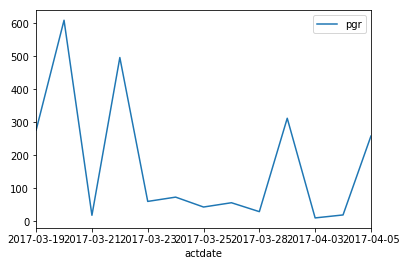

In [45]:
show_player_pgr('fd623cb00f')

### Сводная таблица

In [96]:
dau_pact = pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
dau_pact_table = dau_pact.drop(['clusters', 'revenue', 'quest', 
                          'm_quests', 'crystals', 'store_enters', 
                          'transactions', 'country'], axis='columns')

In [97]:
dau_pact_table['day_n'] = (pd.to_datetime(dau_pact_table['actdate']) - 
                           pd.to_datetime(dau_pact_table['regdate'])).dt.days
dau_pact_table = dau_pact_table[dau_pact_table.day_n < 31 + 14].reset_index()
dau_pact_table = dau_pact_table[pd.to_datetime(dau_pact_table.regdate) < pd.to_datetime('2017-04-15')].reset_index()
dau_pact_table = dau_pact_table.pivot_table(values='pgr', columns=['day_n'], index=['id'], aggfunc='sum')

In [67]:
print(dau_pact_table)

               0.0     1.0     2.0     3.0     4.0     5.0     6.0     7.0  \
id                                                                           
0001c0d9c5   225.0   169.0   164.0     NaN     NaN    68.0    23.0     NaN   
000249ee3b   227.0    96.0   142.0     NaN     NaN    67.0     NaN     NaN   
0004bbc378   129.0   329.0   131.0     NaN   137.0   134.0    24.0    41.0   
000bc5be57   413.0    81.0   233.0   123.0    92.0    45.0    79.0     NaN   
00137c70eb   550.0    70.0     NaN   180.0     NaN   286.0   230.0   191.0   
001566c949   229.0    42.0   124.0     NaN     NaN     NaN    98.0   230.0   
0016ec0270   416.0   221.0     NaN    93.0    19.0     NaN    45.0   165.0   
001bdcf118   260.0    15.0     NaN     NaN    47.0   162.0   147.0     NaN   
001dcb349d   180.0   339.0    91.0    64.0     NaN    96.0    51.0     NaN   
001e86bb74    55.0    59.0    34.0    73.0    56.0     NaN   142.0    55.0   
001f6f6bda   173.0   478.0    25.0    15.0     NaN   148.0    86

In [5]:
dau_pact_table.to_csv('dau_pact_table.csv')

### Различные признаки

In [21]:
dau_pact_table['m_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9, 
                      10, 11, 12, 13, 14, 15, 16,
                      17, 18, 19, 20, 21, 22, 23, 
                      24, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].count(1)
dau_pact_table['w2_played'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].count(1)
dau_pact_table['w3_played'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].count(1)
dau_pact_table['w4_played'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_max'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
dau_pact_table['w2_max'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
dau_pact_table['w3_max'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
dau_pact_table['w4_max'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
dau_pact_table['w1_mean'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
dau_pact_table['w2_mean'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
dau_pact_table['w3_mean'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
dau_pact_table['w4_mean'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
dau_pact_table['w1_meandmax'] = (dau_pact_table['w1_mean'] / dau_pact_table['w1_max']).replace('NaN', 0)
dau_pact_table['w2_meandmax'] = (dau_pact_table['w2_mean'] / dau_pact_table['w2_max']).replace('NaN', 0)
dau_pact_table['w3_meandmax'] = (dau_pact_table['w3_mean'] / dau_pact_table['w3_max']).replace('NaN', 0)
dau_pact_table['w4_meandmax'] = (dau_pact_table['w4_mean'] / dau_pact_table['w4_max']).replace('NaN', 0)
dau_pact_table['result_played'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
                                                  38, 39, 40, 41, 42, 43, 44]].count(1)
dau_pact_table['is_active'] = (dau_pact_table['result_played'] > 1) * 1
dau_pact_table['result_category'] = (dau_pact_table['result_played'] / 4).round()
#dau_pact_table['result_intensity'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
#                                                  38, 39, 40, 41, 42, 43, 44]].replace('NaN', 0).mean(1)
print(dau_pact_table)

               id     0.0     1.0     2.0     3.0     4.0     5.0     6.0  \
0      0001c0d9c5   225.0   169.0   164.0     NaN     NaN    68.0    23.0   
1      000249ee3b   227.0    96.0   142.0     NaN     NaN    67.0     NaN   
2      0004bbc378   129.0   329.0   131.0     NaN   137.0   134.0    24.0   
3      000bc5be57   413.0    81.0   233.0   123.0    92.0    45.0    79.0   
4      00137c70eb   550.0    70.0     NaN   180.0     NaN   286.0   230.0   
5      001566c949   229.0    42.0   124.0     NaN     NaN     NaN    98.0   
6      0016ec0270   416.0   221.0     NaN    93.0    19.0     NaN    45.0   
7      001bdcf118   260.0    15.0     NaN     NaN    47.0   162.0   147.0   
8      001dcb349d   180.0   339.0    91.0    64.0     NaN    96.0    51.0   
9      001e86bb74    55.0    59.0    34.0    73.0    56.0     NaN   142.0   
10     001f6f6bda   173.0   478.0    25.0    15.0     NaN   148.0    86.0   
11     00217a789a   123.0     7.0    56.0     NaN     8.0     NaN     NaN   

### Попытки предсказаний, точность

In [60]:
#dau_pact_table['predict_intensity'] = (dau_pact_table['w1_mean'] * 0.2 
#                                       + dau_pact_table['w2_mean'] * 0.3 
#                                       + dau_pact_table['w3_mean'] * 0.5
#                                       + dau_pact_table['w4_mean'] * 1)
#dau_pact_table['intensity_acc'] = ((dau_pact_table['result_intensity'] - dau_pact_table['predict_intensity']).abs()
#                                   / (dau_pact_table['result_intensity']))
#dau_pact_table['predict_played'] = (dau_pact_table['w1_played'] * 0.2
#                                    + dau_pact_table['w2_played'] * 0.3
#                                    + dau_pact_table['w3_played'] * 0.5
#                                    + dau_pact_table['w4_played'] * 1).round()
#dau_pact_table['played_acc'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_played']).abs()
#                                / (dau_pact_table['result_played']))
dau_pact_table['clf_acc'] = (dau_pact_table['is_active'] == dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e1'] = (dau_pact_table['is_active'] > dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e2'] = (dau_pact_table['is_active'] < dau_pact_table['predict_active']) * 1
#dau_pact_table['prd_acc'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_days']).abs()
#                                / (dau_pact_table['result_played']))
dau_pact_table['prd_delta'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_days']).abs())
dau_pact_table['overall_delta'] = ((dau_pact_table['result_played'] * dau_pact_table['is_active'] - dau_pact_table['predict_days'] * dau_pact_table['predict_active']).abs())
#dau_pact_table['category_delta'] = ((dau_pact_table['result_category'] - dau_pact_table['predict_category'])).abs()
#print(dau_pact_table)
#dau_pact_table = dau_pact_table.set_index('id')

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Среднее отклонение классификатора активности: 0.106341840681
Ошибка классификатора 1 рода (игрок на самом деле активен): 0.0641918020108
Ошибка классификатора 2 рода (игрок на самом деле неактивен): 0.0421500386698
Среднее отклонение предсказателя дней: 2.64546913333
Среднее общее отклонение: 1.14459521313
[8957, 1642, 510, 113]
[2324, 1348, 337, 72]


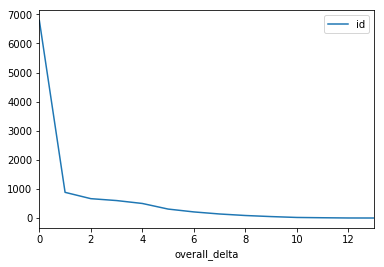

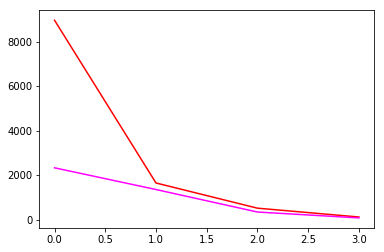

In [61]:
#num_inf = 0
#sum_infs = 0
#sum_v = 0
#num_v = 0
#nans = 0
prd_delta = dau_pact_table[16000:][dau_pact_table['is_active'] == 1]['prd_delta'].mean()
clf_delta = 1 - dau_pact_table['clf_acc'][16000:].mean()
clf_e1 = dau_pact_table['clf_e1'][16000:].mean()
clf_e2 = dau_pact_table['clf_e2'][16000:].mean()
overall_delta = dau_pact_table['overall_delta'][16000:].mean()
#category_delta = dau_pact_table['category_delta'][16000:].mean()
#for i in range(0, 26435):
#    #print(dau_pact_table['played_acc'][i])
#    if np.isnan(dau_pact_table['regr_acc'][i]):
#        nans += 1
#    elif not np.isfinite(dau_pact_table['regr_acc'][i]):
#        sum_infs += dau_pact_table['regr_predict_played'][i]
#        num_inf += 1
#    else:
#        sum_v += dau_pact_table['regr_acc'][i]
#        num_v += 1
#print("Среднее процентное отклонение (не inf):", sum_v / num_v * 100, '%')
#print("Среднее отклонение для acc=inf (дни): ", sum_infs / num_inf)
#print("Среднее отклонение (дни):", delta)
print('Среднее отклонение классификатора активности:', clf_delta)
print('Ошибка классификатора 1 рода (игрок на самом деле активен):', clf_e1)
print('Ошибка классификатора 2 рода (игрок на самом деле неактивен):', clf_e2)
print('Среднее отклонение предсказателя дней:', prd_delta)
print('Среднее общее отклонение:', overall_delta)
#print('Среднее отклонение категории:', category_delta)
overall_delta_round = dau_pact_table['overall_delta'][16000:].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
active_delta_round = dau_pact_table[16000:][dau_pact_table['is_active'] == 1.0]['overall_delta'].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
overall_delta_round.plot()
#print(overall_delta_round)
#print(active_delta_round)
categories_delta = [int(overall_delta_round[0:3].sum()), int(overall_delta_round[3:6].sum()), int(overall_delta_round[6:9].sum()), int(overall_delta_round[9:14].sum())]
active_categories_delta = [int(active_delta_round[0:3].sum()), int(active_delta_round[3:6].sum()), int(active_delta_round[6:9].sum()), int(active_delta_round[9:14].sum())]
print(categories_delta)
print(active_categories_delta)
plt.show()
plt.plot(categories_delta, color='red')
plt.plot(active_categories_delta, color='magenta')
plt.show()

In [98]:
dau_pact_features = pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
features = ['pgr', 'clusters', 'quest', 'm_quests', 'transactions']
dau_pact_features['day_n'] = (pd.to_datetime(dau_pact_features['actdate']) - 
                           pd.to_datetime(dau_pact_features['regdate'])).dt.days
dau_pact_features = dau_pact_features[dau_pact_features.day_n < 31 + 14]
dau_pact_features = dau_pact_features[pd.to_datetime(dau_pact_features.regdate) < pd.to_datetime('2017-04-15')]
pay_players = pd.read_csv('pay_players.csv').drop('Unnamed: 0', axis='columns')
feature_table = pd.DataFrame(pay_players)
clf_features = []
#print(feature_table)
for feat in features:
    dau_pact_features_tmp = dau_pact_features.pivot_table(values=feat, columns=['day_n'], index=['id'], aggfunc='sum')
    dau_pact_features_tmp[feat+'_w1_mean'] = dau_pact_features_tmp[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w2_mean'] = dau_pact_features_tmp[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w3_mean'] = dau_pact_features_tmp[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w4_mean'] = dau_pact_features_tmp[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w1_max'] = dau_pact_features_tmp[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w2_max'] = dau_pact_features_tmp[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w3_max'] = dau_pact_features_tmp[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w4_max'] = dau_pact_features_tmp[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w1_meandmax'] = (dau_pact_features_tmp[feat+'_w1_mean'] / dau_pact_features_tmp[feat+'_w1_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w2_meandmax'] = (dau_pact_features_tmp[feat+'_w2_mean'] / dau_pact_features_tmp[feat+'_w2_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w3_meandmax'] = (dau_pact_features_tmp[feat+'_w3_mean'] / dau_pact_features_tmp[feat+'_w3_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w4_meandmax'] = (dau_pact_features_tmp[feat+'_w4_mean'] / dau_pact_features_tmp[feat+'_w4_max']).replace('NaN', 0)
    #for col in dau_pact_features_tmp.columns[:-4]:
    #    if col >= 3.0 and col <= 30.0:
    #        clf_features.append(feat+'_'+str(col))
    #    dau_pact_features_tmp.rename(columns={col: feat+'_'+str(col)}, inplace=True)
    dau_pact_features_tmp = dau_pact_features_tmp.reset_index()
    #print(dau_pact_features_tmp[feat+'_w1_mean'])
    
    #print(pd.DataFrame({'id': dau_pact_features_tmp['id'],
    #                                                      feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                      feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                      feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                      feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean']}))
    #print(feature_table)
    feature_table = pd.merge(feature_table, pd.DataFrame({'id': dau_pact_features_tmp['id'],
                                                          feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
                                                          feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
                                                          feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
                                                          feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean'],
                                                          feat+'_w1_max': dau_pact_features_tmp[feat+'_w1_max'],
                                                          feat+'_w2_max': dau_pact_features_tmp[feat+'_w2_max'],
                                                          feat+'_w3_max': dau_pact_features_tmp[feat+'_w3_max'],
                                                          feat+'_w4_max': dau_pact_features_tmp[feat+'_w4_max'],
                                                          feat+'_w1_meandmax': dau_pact_features_tmp[feat+'_w1_meandmax'],
                                                          feat+'_w2_meandmax': dau_pact_features_tmp[feat+'_w2_meandmax'],
                                                          feat+'_w3_meandmax': dau_pact_features_tmp[feat+'_w3_meandmax'],
                                                          feat+'_w4_meandmax': dau_pact_features_tmp[feat+'_w4_meandmax']}), 
                             how='inner', on=['id'])
    clf_features += [feat+'_w1_mean',
                     feat+'_w2_mean',
                     feat+'_w3_mean',
                     feat+'_w4_mean']#,
                     #feat+'_w1_max',
                     #feat+'_w2_max',
                     #feat+'_w3_max',
                     #feat+'_w4_max',
                     #feat+'_w1_meandmax',
                     #feat+'_w2_meandmax',
                     #feat+'_w3_meandmax',
                     #feat+'_w4_meandmax']
    #feature_table = pd.merge(feature_table, dau_pact_features_tmp, on='id', how='inner')
    #print(feature_table)
    #print(pd.DataFrame([dau_pact_features_tmp['id'],
    #                                                  dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w4_mean']]))
    #dau_pact_features[feat+'_w1_mean'] = dau_pact_features_tmp[feat+'_w1_mean']
    #dau_pact_features[feat+'_w2_mean'] = dau_pact_features_tmp[feat+'_w2_mean']
    #dau_pact_features[feat+'_w3_mean'] = dau_pact_features_tmp[feat+'_w3_mean']
    #dau_pact_features[feat+'_w4_mean'] = dau_pact_features_tmp[feat+'_w4_mean']
    #print(dau_pact_features)

In [99]:
feature_table.to_csv('feature_table.csv', index=False)

In [100]:
feature_table = pd.read_csv('feature_table.csv')
dau_pact_table = pd.merge(dau_pact_table.reset_index(), feature_table, on='id', how='inner')

In [101]:
print(dau_pact_table)

               id     0.0     1.0     2.0     3.0     4.0     5.0     6.0  \
0      0001c0d9c5   225.0   169.0   164.0     NaN     NaN    68.0    23.0   
1      000249ee3b   227.0    96.0   142.0     NaN     NaN    67.0     NaN   
2      0004bbc378   129.0   329.0   131.0     NaN   137.0   134.0    24.0   
3      000bc5be57   413.0    81.0   233.0   123.0    92.0    45.0    79.0   
4      00137c70eb   550.0    70.0     NaN   180.0     NaN   286.0   230.0   
5      001566c949   229.0    42.0   124.0     NaN     NaN     NaN    98.0   
6      0016ec0270   416.0   221.0     NaN    93.0    19.0     NaN    45.0   
7      001bdcf118   260.0    15.0     NaN     NaN    47.0   162.0   147.0   
8      001dcb349d   180.0   339.0    91.0    64.0     NaN    96.0    51.0   
9      001e86bb74    55.0    59.0    34.0    73.0    56.0     NaN   142.0   
10     001f6f6bda   173.0   478.0    25.0    15.0     NaN   148.0    86.0   
11     00217a789a   123.0     7.0    56.0     NaN     8.0     NaN     NaN   

In [102]:
dau_pact_table['m_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9, 
                      10, 11, 12, 13, 14, 15, 16,
                      17, 18, 19, 20, 21, 22, 23, 
                      24, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].count(1)
dau_pact_table['w2_played'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].count(1)
dau_pact_table['w3_played'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].count(1)
dau_pact_table['w4_played'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].count(1)
#dau_pact_table['w1_max'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
#dau_pact_table['w2_max'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
#dau_pact_table['w3_max'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
#dau_pact_table['w4_max'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
#dau_pact_table['w1_mean'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
#dau_pact_table['w2_mean'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
#dau_pact_table['w3_mean'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
#dau_pact_table['w4_mean'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
#dau_pact_table['w1_meandmax'] = (dau_pact_table['w1_mean'] / dau_pact_table['w1_max']).replace('NaN', 0)
#dau_pact_table['w2_meandmax'] = (dau_pact_table['w2_mean'] / dau_pact_table['w2_max']).replace('NaN', 0)
#dau_pact_table['w3_meandmax'] = (dau_pact_table['w3_mean'] / dau_pact_table['w3_max']).replace('NaN', 0)
#dau_pact_table['w4_meandmax'] = (dau_pact_table['w4_mean'] / dau_pact_table['w4_max']).replace('NaN', 0)
dau_pact_table['result_played'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
                                                  38, 39, 40, 41, 42, 43, 44]].count(1)
dau_pact_table['is_active'] = (dau_pact_table['result_played'] > 0) * 1
dau_pact_table['result_category'] = (dau_pact_table['result_played'] / 4).round()
clf_features += ['w1_played', 'w2_played', 'w3_played', 'w4_played']
dau_pact_table = dau_pact_table.set_index('id')

In [20]:
tmp = metrics.confusion_matrix(dau_pact_table[16000:]['is_active'], dau_pact_table[16000:]['predict_active'])

In [13]:
print(tmp)

[[6641  422]
 [ 678 2694]]


In [16]:
country_feature = (pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns').set_index('id')['country']).reset_index()
map_country = dict()
for i in range(len(country_feature['id'])):
    map_country[country_feature['id'][i]] = country_feature['country'][i]
country_array = []
id_array = []
for _id in map_country:
    id_array.append(_id)
    country_array.append(map_country[_id])
country_feature = pd.get_dummies(pd.DataFrame({'id': id_array, 'country': country_array}).set_index('id')['country']).reset_index()

In [50]:
print(country_feature)
print(country_feature.columns)

               id  --  AE  AM  AR  AT  AU  AW  AZ  BA ...  TT  TW  TZ  UA  US  \
0      8657fd9864   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
1      384332f747   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
2      22139ab537   0   1   0   0   0   0   0   0   0 ...   0   0   0   0   0   
3      6235e3e291   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
4      2222236ac7   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
5      a3edc8f3c3   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
6      5aa4215ec4   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
7      e990bd8e89   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
8      3da00c9d73   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
9      5bf13afc59   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
10     4b497cbb05   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
11     11420820a9   0   0   

In [51]:
#print(dau_pact_table.reset_index())
dau_pact_table = pd.merge(dau_pact_table.reset_index(), country_feature, on='id', how='left').set_index('id')
clf_features += list(country_feature.columns)[1:]

In [2]:
pact = pd.read_csv('practice_pact_and.csv', sep='|')
players_regdates = pd.DataFrame({'id': pact[pact.transactions > 0]['id'], 'regdate': pact[pact.transactions > 0]['regdate']}).drop_duplicates().reset_index().drop('index', axis='columns')
del pact
sessions = pd.read_csv('practice_sessions_and.csv', sep='|')
pay_players_sessions = pd.merge(players_regdates, sessions, on='id', how='left').drop(['session_number'], axis='columns')
pay_players_sessions['day_n'] = (pd.to_datetime(pay_players_sessions['actdate']) - 
                           pd.to_datetime(pay_players_sessions['regdate'])).dt.days
pay_players_sessions = pay_players_sessions[pay_players_sessions.day_n < 31 + 14]
pay_players_sessions = pay_players_sessions[pay_players_sessions.day_n >= 0]
pay_players_sessions = pay_players_sessions[pd.to_datetime(pay_players_sessions.regdate) < pd.to_datetime('2017-04-15')]
pay_players_sessions.to_csv('pay_players_sessions.csv', index=False)

In [68]:
pay_players_sessions = pd.read_csv('pay_players_sessions.csv')
sum_len_sess = pay_players_sessions.pivot_table(values='session_length', columns=['day_n'], index=['id'], aggfunc='sum')
n_sess = pay_players_sessions.pivot_table(values='session_length', columns=['day_n'], index=['id'], aggfunc='count')

In [106]:
n_sess['sess_w1_mean'] = n_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
n_sess['sess_w2_mean'] = n_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
n_sess['sess_w3_mean'] = n_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
n_sess['sess_w4_mean'] = n_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
n_sess['sess_w1_max'] = n_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
n_sess['sess_w2_max'] = n_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
n_sess['sess_w3_max'] = n_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
n_sess['sess_w4_max'] = n_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
n_sess['sess_w1_meandmax'] = n_sess['sess_w1_mean'] / n_sess['sess_w1_max']
n_sess['sess_w2_meandmax'] = n_sess['sess_w2_mean'] / n_sess['sess_w2_max']
n_sess['sess_w3_meandmax'] = n_sess['sess_w3_mean'] / n_sess['sess_w3_max']
n_sess['sess_w4_meandmax'] = n_sess['sess_w4_mean'] / n_sess['sess_w4_max']
clf_features += ['sess_w1_mean',
                 'sess_w2_mean',
                 'sess_w3_mean',
                 'sess_w4_mean']#,
                 #'sess_w1_max',
                 #'sess_w2_max',
                 #'sess_w3_max',
                 #'sess_w4_max',
                 #'sess_w1_meandmax',
                 #'sess_w2_meandmax',
                 #'sess_w3_meandmax',
                 #'sess_w4_meandmax']
n_sess.reset_index(inplace=True)
sum_len_sess['lensess_w1_mean'] = sum_len_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w2_mean'] = sum_len_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w3_mean'] = sum_len_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w4_mean'] = sum_len_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w1_max'] = sum_len_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w2_max'] = sum_len_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w3_max'] = sum_len_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w4_max'] = sum_len_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w1_meandmax'] = sum_len_sess['lensess_w1_mean'] / sum_len_sess['lensess_w1_max']
sum_len_sess['lensess_w2_meandmax'] = sum_len_sess['lensess_w2_mean'] / sum_len_sess['lensess_w2_max']
sum_len_sess['lensess_w3_meandmax'] = sum_len_sess['lensess_w3_mean'] / sum_len_sess['lensess_w3_max']
sum_len_sess['lensess_w4_meandmax'] = sum_len_sess['lensess_w4_mean'] / sum_len_sess['lensess_w4_max']
sum_len_sess.reset_index(inplace=True)
sess_features = pd.DataFrame({'id': n_sess['id'],
                              'sess_w1_mean': n_sess['sess_w1_mean'],
                              'sess_w2_mean': n_sess['sess_w2_mean'],
                              'sess_w3_mean': n_sess['sess_w3_mean'],
                              'sess_w4_mean': n_sess['sess_w4_mean'],
                              #'sess_w1_max': n_sess['sess_w1_max'],
                              #'sess_w2_max': n_sess['sess_w2_max'],
                              #'sess_w3_max': n_sess['sess_w3_max'],
                              #'sess_w4_max': n_sess['sess_w4_max'],
                              'sess_w1_meandmax': n_sess['sess_w1_meandmax'],
                              'sess_w2_meandmax': n_sess['sess_w2_meandmax'],
                              'sess_w3_meandmax': n_sess['sess_w3_meandmax'],
                              'sess_w4_meandmax': n_sess['sess_w4_meandmax']})
sess_features = pd.merge(sess_features, pd.DataFrame({'id': sum_len_sess['id'],
                              #'lensess_w1_mean': sum_len_sess['lensess_w1_mean'],
                              #'lensess_w2_mean': sum_len_sess['lensess_w2_mean'],
                              #'lensess_w3_mean': sum_len_sess['lensess_w3_mean'],
                              #'lensess_w4_mean': sum_len_sess['lensess_w4_mean'],
                              #'lensess_w1_max': sum_len_sess['lensess_w1_max'],
                              #'lensess_w2_max': sum_len_sess['lensess_w2_max'],
                              #'lensess_w3_max': sum_len_sess['lensess_w3_max'],
                              #'lensess_w4_max': sum_len_sess['lensess_w4_max'],
                              'lensess_w1_meandmax': sum_len_sess['lensess_w1_meandmax'],
                              'lensess_w2_meandmax': sum_len_sess['lensess_w2_meandmax'],
                              'lensess_w3_meandmax': sum_len_sess['lensess_w3_meandmax'],
                              'lensess_w4_meandmax': sum_len_sess['lensess_w4_meandmax']}),
                        how='inner', on='id')
clf_features += [#'lensess_w1_mean',
                 #'lensess_w2_mean',
                 #'lensess_w3_mean',
                 #'lensess_w4_mean',
                 #'lensess_w1_max',
                 #'lensess_w2_max',
                 #'lensess_w3_max',
                 #'lensess_w4_max',
                 'lensess_w1_meandmax',
                 'lensess_w2_meandmax',
                 'lensess_w3_meandmax',
                 'lensess_w4_meandmax']

In [107]:
dau_pact_table = pd.merge(dau_pact_table.reset_index(), sess_features, on='id', how='inner')

# Составляем сводную таблицу

Ниже приведен пример для таблицы активных игроков. Для того, чтобы сделать таблицу платящих игроков, достаточно заменить название файла active_players_dau_pact.csv на pay_players_dau_pact.csv.

In [7]:
dau_pact = pd.read_csv('active_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
dau_pact_table = dau_pact.drop(['clusters', 'revenue', 'quest', 
                          'm_quests', 'crystals', 'store_enters', 
                          'transactions', 'country'], axis='columns')
dau_pact_table['day_n'] = (pd.to_datetime(dau_pact_table['actdate']) - 
                           pd.to_datetime(dau_pact_table['regdate'])).dt.days
dau_pact_table = dau_pact_table[dau_pact_table.day_n < 31 + 14].reset_index()
dau_pact_table = dau_pact_table[pd.to_datetime(dau_pact_table.regdate) < pd.to_datetime('2017-04-15')].reset_index()
dau_pact_table = dau_pact_table.pivot_table(values='pgr', columns=['day_n'], index=['id'], aggfunc='sum')
del dau_pact

Составляем таблицу фич:

In [9]:
dau_pact_features = pd.read_csv('active_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
features = ['pgr', 'clusters', 'quest', 'm_quests']
dau_pact_features['day_n'] = (pd.to_datetime(dau_pact_features['actdate']) - 
                           pd.to_datetime(dau_pact_features['regdate'])).dt.days
dau_pact_features = dau_pact_features[dau_pact_features.day_n < 31 + 14]
dau_pact_features = dau_pact_features[pd.to_datetime(dau_pact_features.regdate) < pd.to_datetime('2017-04-15')]
#pay_players = pd.read_csv('pay_players.csv').drop('Unnamed: 0', axis='columns')
feature_table = pd.DataFrame(dau_pact_features['id'].drop_duplicates())
clf_features = []
#print(feature_table)
for feat in features:
    dau_pact_features_tmp = dau_pact_features.pivot_table(values=feat, columns=['day_n'], index=['id'], aggfunc='sum')
    dau_pact_features_tmp[feat+'_w1_mean'] = dau_pact_features_tmp[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w2_mean'] = dau_pact_features_tmp[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w3_mean'] = dau_pact_features_tmp[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w4_mean'] = dau_pact_features_tmp[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w1_max'] = dau_pact_features_tmp[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w2_max'] = dau_pact_features_tmp[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w3_max'] = dau_pact_features_tmp[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w4_max'] = dau_pact_features_tmp[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w1_meandmax'] = (dau_pact_features_tmp[feat+'_w1_mean'] / dau_pact_features_tmp[feat+'_w1_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w2_meandmax'] = (dau_pact_features_tmp[feat+'_w2_mean'] / dau_pact_features_tmp[feat+'_w2_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w3_meandmax'] = (dau_pact_features_tmp[feat+'_w3_mean'] / dau_pact_features_tmp[feat+'_w3_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w4_meandmax'] = (dau_pact_features_tmp[feat+'_w4_mean'] / dau_pact_features_tmp[feat+'_w4_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w1_av_deviat'] = (dau_pact_features_tmp[feat+'_w1_mean'] - dau_pact_features_tmp[3.0]).abs()
    for i in [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
        dau_pact_features_tmp[feat+'_w1_av_deviat'] += (dau_pact_features_tmp[feat+'_w1_mean'] - dau_pact_features_tmp[i]).abs()
    dau_pact_features_tmp[feat+'_w1_av_deviat'] /= 7
    dau_pact_features_tmp[feat+'_w2_av_deviat'] = (dau_pact_features_tmp[feat+'_w2_mean'] - dau_pact_features_tmp[10.0]).abs()
    for i in [11.0, 12.0, 13.0, 14.0, 15.0, 16.0]:
        dau_pact_features_tmp[feat+'_w2_av_deviat'] += (dau_pact_features_tmp[feat+'_w2_mean'] - dau_pact_features_tmp[i]).abs()
    dau_pact_features_tmp[feat+'_w2_av_deviat'] /= 7
    dau_pact_features_tmp[feat+'_w3_av_deviat'] = (dau_pact_features_tmp[feat+'_w3_mean'] - dau_pact_features_tmp[17.0]).abs()
    for i in [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]:
        dau_pact_features_tmp[feat+'_w3_av_deviat'] += (dau_pact_features_tmp[feat+'_w3_mean'] - dau_pact_features_tmp[i]).abs()
    dau_pact_features_tmp[feat+'_w3_av_deviat'] /= 7
    dau_pact_features_tmp[feat+'_w4_av_deviat'] = (dau_pact_features_tmp[feat+'_w4_mean'] - dau_pact_features_tmp[24.0]).abs()
    for i in [25.0, 26.0, 27.0, 28.0, 29.0, 30.0]:
        dau_pact_features_tmp[feat+'_w4_av_deviat'] += (dau_pact_features_tmp[feat+'_w4_mean'] - dau_pact_features_tmp[i]).abs()
    dau_pact_features_tmp[feat+'_w4_av_deviat'] /= 7
    #for col in dau_pact_features_tmp.columns[:-4]:
    #    if col >= 3.0 and col <= 30.0:
    #        clf_features.append(feat+'_'+str(col))
    #    dau_pact_features_tmp.rename(columns={col: feat+'_'+str(col)}, inplace=True)
    dau_pact_features_tmp = dau_pact_features_tmp.reset_index()
    #print(dau_pact_features_tmp[feat+'_w1_mean'])
    
    #print(pd.DataFrame({'id': dau_pact_features_tmp['id'],
    #                                                      feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                      feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                      feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                      feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean']}))
    #print(feature_table)
    feature_table = pd.merge(feature_table, pd.DataFrame({'id': dau_pact_features_tmp['id'],
                                                          feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
                                                          feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
                                                          feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
                                                          feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean'],
                                                          #feat+'_w1_max': dau_pact_features_tmp[feat+'_w1_max'],
                                                          #feat+'_w2_max': dau_pact_features_tmp[feat+'_w2_max'],
                                                          #feat+'_w3_max': dau_pact_features_tmp[feat+'_w3_max'],
                                                          #feat+'_w4_max': dau_pact_features_tmp[feat+'_w4_max'],
                                                          feat+'_w1_meandmax': dau_pact_features_tmp[feat+'_w1_meandmax'],
                                                          feat+'_w2_meandmax': dau_pact_features_tmp[feat+'_w2_meandmax'],
                                                          feat+'_w3_meandmax': dau_pact_features_tmp[feat+'_w3_meandmax'],
                                                          feat+'_w4_meandmax': dau_pact_features_tmp[feat+'_w4_meandmax'],
                                                          #feat+'_w1_av_deviat': dau_pact_features_tmp[feat+'_w1_av_deviat'],
                                                          #feat+'_w2_av_deviat': dau_pact_features_tmp[feat+'_w2_av_deviat'],
                                                          #feat+'_w3_av_deviat': dau_pact_features_tmp[feat+'_w3_av_deviat'],
                                                          #feat+'_w4_av_deviat': dau_pact_features_tmp[feat+'_w4_av_deviat']
                                                         }), 
                             how='inner', on=['id'])
    clf_features += [feat+'_w1_mean',
                     feat+'_w2_mean',
                     feat+'_w3_mean',
                     feat+'_w4_mean',
                     #feat+'_w1_max',
                     #feat+'_w2_max',
                     #feat+'_w3_max',
                     #feat+'_w4_max',
                     feat+'_w1_meandmax',
                     feat+'_w2_meandmax',
                     feat+'_w3_meandmax',
                     feat+'_w4_meandmax'#,
                     #feat+'_w1_av_deviat',
                     #feat+'_w2_av_deviat',
                     #feat+'_w3_av_deviat',
                     #feat+'_w4_av_deviat'
                    ]
    print(feat + ': done')
    #feature_table = pd.merge(feature_table, dau_pact_features_tmp, on='id', how='inner')
    #print(feature_table)
    #print(pd.DataFrame([dau_pact_features_tmp['id'],
    #                                                  dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w4_mean']]))
    #print(dau_pact_features)

pgr: done
clusters: done
quest: done
m_quests: done


In [4]:
features = ['pgr', 'clusters', 'quest', 'm_quests', 'transactions', 'revenue']
clf_features = []
for feat in features:
    clf_features += [feat+'_w1_mean',
                     feat+'_w2_mean',
                     feat+'_w3_mean',
                     feat+'_w4_mean',
                     #feat+'_w1_max',
                     #feat+'_w2_max',
                     #feat+'_w3_max',
                     #feat+'_w4_max',
                     feat+'_w1_meandmax',
                     feat+'_w2_meandmax',
                     feat+'_w3_meandmax',
                     feat+'_w4_meandmax',
                     feat+'_w1_av_deviat',
                     feat+'_w2_av_deviat',
                     feat+'_w3_av_deviat',
                     feat+'_w4_av_deviat']

In [10]:
#print(feature_table)
#print(feature_table.columns)
feature_table.to_csv('feature_table.csv', index=False)

In [11]:
feature_table = pd.read_csv('feature_table.csv')

Объединяем заготовку сводной таблицы и таблицу фич:

In [12]:
dau_pact_table = pd.merge(dau_pact_table.reset_index(), feature_table, on='id', how='inner')
dau_pact_table.set_index('id', inplace=True)

Дополнительные фичи и столбцы:

In [13]:
dau_pact_table['m_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9, 
                      10, 11, 12, 13, 14, 15, 16,
                      17, 18, 19, 20, 21, 22, 23, 
                      24, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].count(1)
dau_pact_table['w2_played'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].count(1)
dau_pact_table['w3_played'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].count(1)
dau_pact_table['w4_played'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].count(1)
#dau_pact_table['w1_max'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
#dau_pact_table['w2_max'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
#dau_pact_table['w3_max'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
#dau_pact_table['w4_max'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
#dau_pact_table['w1_mean'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
#dau_pact_table['w2_mean'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
#dau_pact_table['w3_mean'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
#dau_pact_table['w4_mean'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
#dau_pact_table['w1_meandmax'] = (dau_pact_table['w1_mean'] / dau_pact_table['w1_max']).replace('NaN', 0)
#dau_pact_table['w2_meandmax'] = (dau_pact_table['w2_mean'] / dau_pact_table['w2_max']).replace('NaN', 0)
#dau_pact_table['w3_meandmax'] = (dau_pact_table['w3_mean'] / dau_pact_table['w3_max']).replace('NaN', 0)
#dau_pact_table['w4_meandmax'] = (dau_pact_table['w4_mean'] / dau_pact_table['w4_max']).replace('NaN', 0)
dau_pact_table['result_played'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
                                                  38, 39, 40, 41, 42, 43, 44]].count(1)
dau_pact_table['is_active'] = (dau_pact_table['result_played'] > 0) * 1
dau_pact_table['result_category'] = (dau_pact_table['result_played'] / 4).round()
clf_features += ['w1_played', 'w2_played', 'w3_played', 'w4_played']
dau_pact_table = dau_pact_table.drop([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 
                     10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 
                     17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0,
                     24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0,
                     31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0,
                     38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0], axis='columns')
dau_pact_table = dau_pact_table[dau_pact_table['w3_played'] + dau_pact_table['w4_played'] > 1]
print(dau_pact_table)

            pgr_w1_mean  pgr_w1_meandmax  pgr_w2_mean  pgr_w2_meandmax  \
id                                                                       
00009465d8    52.000000         0.650000    33.000000         0.458333   
000111ed0d    86.000000         0.432161    47.666667         0.866667   
000199468b          NaN              NaN    39.500000         0.858696   
000209d54e    99.000000         1.000000    49.250000         0.600610   
0002679403    55.500000         0.451220    27.000000         0.710526   
0004bbc378    89.500000         0.653285   107.428571         0.521498   
0007a3e03f   135.857143         0.328952   107.166667         0.334896   
0007a3e999   301.714286         0.583587   124.142857         0.709388   
0008c1cfcd   310.857143         0.784993   294.285714         0.594517   
000a445af4   308.000000         0.421341    82.200000         0.444324   
000bc5be57   113.000000         0.504464   110.166667         0.466808   
000bdd1bc1    47.000000         1.0000

Составляем сводные таблицы на основе данных 3-й таблицы:

In [7]:
pay_players_sessions = pd.read_csv('pay_players_sessions.csv')
sum_len_sess = pay_players_sessions.pivot_table(values='session_length', columns=['day_n'], index=['id'], aggfunc='sum')
n_sess = pay_players_sessions.pivot_table(values='session_length', columns=['day_n'], index=['id'], aggfunc='count')

In [8]:
n_sess['sess_w1_mean'] = n_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
n_sess['sess_w2_mean'] = n_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
n_sess['sess_w3_mean'] = n_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
n_sess['sess_w4_mean'] = n_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
n_sess['sess_w1_max'] = n_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
n_sess['sess_w2_max'] = n_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
n_sess['sess_w3_max'] = n_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
n_sess['sess_w4_max'] = n_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
n_sess['sess_w1_meandmax'] = n_sess['sess_w1_mean'] / n_sess['sess_w1_max']
n_sess['sess_w2_meandmax'] = n_sess['sess_w2_mean'] / n_sess['sess_w2_max']
n_sess['sess_w3_meandmax'] = n_sess['sess_w3_mean'] / n_sess['sess_w3_max']
n_sess['sess_w4_meandmax'] = n_sess['sess_w4_mean'] / n_sess['sess_w4_max']
n_sess['sess_w1_av_deviat'] = (n_sess['sess_w1_mean'] - n_sess[3.0]).abs()
for i in [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    n_sess['sess_w1_av_deviat'] += (n_sess['sess_w1_mean'] - n_sess[i]).abs()
n_sess['sess_w1_av_deviat'] /= 7
n_sess['sess_w2_av_deviat'] = (n_sess['sess_w2_mean'] - n_sess[10.0]).abs()
for i in [11.0, 12.0, 13.0, 14.0, 15.0, 16.0]:
    n_sess['sess_w2_av_deviat'] += (n_sess['sess_w2_mean'] - n_sess[i]).abs()
n_sess['sess_w2_av_deviat'] /= 7
n_sess['sess_w3_av_deviat'] = (n_sess['sess_w3_mean'] - n_sess[17.0]).abs()
for i in [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]:
    n_sess['sess_w3_av_deviat'] += (n_sess['sess_w3_mean'] - n_sess[i]).abs()
n_sess['sess_w3_av_deviat'] /= 7
n_sess['sess_w4_av_deviat'] = (n_sess['sess_w4_mean'] - n_sess[24.0]).abs()
for i in [25.0, 26.0, 27.0, 28.0, 29.0, 30.0]:
    n_sess['sess_w4_av_deviat'] += (n_sess['sess_w4_mean'] - n_sess[i]).abs()
n_sess['sess_w4_av_deviat'] /= 7
clf_features += ['sess_w1_mean',
                 'sess_w2_mean',
                 'sess_w3_mean',
                 'sess_w4_mean',
                 #'sess_w1_max',
                 #'sess_w2_max',
                 #'sess_w3_max',
                 #'sess_w4_max',
                 'sess_w1_meandmax',
                 'sess_w2_meandmax',
                 'sess_w3_meandmax',
                 'sess_w4_meandmax',
                 'sess_w1_av_deviat',
                 'sess_w2_av_deviat',
                 'sess_w3_av_deviat',
                 'sess_w4_av_deviat']
n_sess.reset_index(inplace=True)
sum_len_sess['lensess_w1_mean'] = sum_len_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w2_mean'] = sum_len_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w3_mean'] = sum_len_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w4_mean'] = sum_len_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w1_max'] = sum_len_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w2_max'] = sum_len_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w3_max'] = sum_len_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w4_max'] = sum_len_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w1_meandmax'] = sum_len_sess['lensess_w1_mean'] / sum_len_sess['lensess_w1_max']
sum_len_sess['lensess_w2_meandmax'] = sum_len_sess['lensess_w2_mean'] / sum_len_sess['lensess_w2_max']
sum_len_sess['lensess_w3_meandmax'] = sum_len_sess['lensess_w3_mean'] / sum_len_sess['lensess_w3_max']
sum_len_sess['lensess_w4_meandmax'] = sum_len_sess['lensess_w4_mean'] / sum_len_sess['lensess_w4_max']
sum_len_sess['lensess_w1_av_deviat'] = (sum_len_sess['lensess_w1_mean'] - sum_len_sess[3.0]).abs()
for i in [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    sum_len_sess['lensess_w1_av_deviat'] += (sum_len_sess['lensess_w1_mean'] - sum_len_sess[i]).abs()
sum_len_sess['lensess_w1_av_deviat'] /= 7
sum_len_sess['lensess_w2_av_deviat'] = (sum_len_sess['lensess_w2_mean'] - sum_len_sess[10.0]).abs()
for i in [11.0, 12.0, 13.0, 14.0, 15.0, 16.0]:
    sum_len_sess['lensess_w2_av_deviat'] += (sum_len_sess['lensess_w2_mean'] - sum_len_sess[i]).abs()
sum_len_sess['lensess_w2_av_deviat'] /= 7
sum_len_sess['lensess_w3_av_deviat'] = (sum_len_sess['lensess_w3_mean'] - sum_len_sess[17.0]).abs()
for i in [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]:
    sum_len_sess['lensess_w3_av_deviat'] += (sum_len_sess['lensess_w3_mean'] - sum_len_sess[i]).abs()
sum_len_sess['lensess_w3_av_deviat'] /= 7
sum_len_sess['lensess_w4_av_deviat'] = (sum_len_sess['lensess_w4_mean'] - sum_len_sess[24.0]).abs()
for i in [25.0, 26.0, 27.0, 28.0, 29.0, 30.0]:
    sum_len_sess['lensess_w4_av_deviat'] += (sum_len_sess['lensess_w4_mean'] - sum_len_sess[i]).abs()
sum_len_sess['lensess_w4_av_deviat'] /= 7
sum_len_sess.reset_index(inplace=True)
sess_features = pd.DataFrame({'id': n_sess['id'],
                              'sess_w1_mean': n_sess['sess_w1_mean'],
                              'sess_w2_mean': n_sess['sess_w2_mean'],
                              'sess_w3_mean': n_sess['sess_w3_mean'],
                              'sess_w4_mean': n_sess['sess_w4_mean'],
                              #'sess_w1_max': n_sess['sess_w1_max'],
                              #'sess_w2_max': n_sess['sess_w2_max'],
                              #'sess_w3_max': n_sess['sess_w3_max'],
                              #'sess_w4_max': n_sess['sess_w4_max'],
                              'sess_w1_meandmax': n_sess['sess_w1_meandmax'],
                              'sess_w2_meandmax': n_sess['sess_w2_meandmax'],
                              'sess_w3_meandmax': n_sess['sess_w3_meandmax'],
                              'sess_w4_meandmax': n_sess['sess_w4_meandmax'],
                              'sess_w1_av_deviat': n_sess['sess_w1_av_deviat'],
                              'sess_w2_av_deviat': n_sess['sess_w2_av_deviat'],
                              'sess_w3_av_deviat': n_sess['sess_w3_av_deviat'],
                              'sess_w4_av_deviat': n_sess['sess_w4_av_deviat']})
sess_features = pd.merge(sess_features, pd.DataFrame({'id': sum_len_sess['id'],
                              'lensess_w1_mean': sum_len_sess['lensess_w1_mean'],
                              'lensess_w2_mean': sum_len_sess['lensess_w2_mean'],
                              'lensess_w3_mean': sum_len_sess['lensess_w3_mean'],
                              'lensess_w4_mean': sum_len_sess['lensess_w4_mean'],
                              #'lensess_w1_max': sum_len_sess['lensess_w1_max'],
                              #'lensess_w2_max': sum_len_sess['lensess_w2_max'],
                              #'lensess_w3_max': sum_len_sess['lensess_w3_max'],
                              #'lensess_w4_max': sum_len_sess['lensess_w4_max'],
                              'lensess_w1_meandmax': sum_len_sess['lensess_w1_meandmax'],
                              'lensess_w2_meandmax': sum_len_sess['lensess_w2_meandmax'],
                              'lensess_w3_meandmax': sum_len_sess['lensess_w3_meandmax'],
                              'lensess_w4_meandmax': sum_len_sess['lensess_w4_meandmax'],
                              'lensess_w1_av_deviat': sum_len_sess['lensess_w1_av_deviat'],
                              'lensess_w2_av_deviat': sum_len_sess['lensess_w2_av_deviat'],
                              'lensess_w3_av_deviat': sum_len_sess['lensess_w3_av_deviat'],
                              'lensess_w4_av_deviat': sum_len_sess['lensess_w4_av_deviat']}),
                        how='inner', on='id')
clf_features += ['lensess_w1_mean',
                 'lensess_w2_mean',
                 'lensess_w3_mean',
                 'lensess_w4_mean',
                 #'lensess_w1_max',
                 #'lensess_w2_max',
                 #'lensess_w3_max',
                 #'lensess_w4_max',
                 'lensess_w1_meandmax',
                 'lensess_w2_meandmax',
                 'lensess_w3_meandmax',
                 'lensess_w4_meandmax',
                 'lensess_w1_av_deviat',
                 'lensess_w2_av_deviat',
                 'lensess_w3_av_deviat',
                 'lensess_w4_av_deviat']

In [9]:
dau_pact_table = pd.merge(dau_pact_table.reset_index(), sess_features, on='id', how='inner')

In [15]:
print(dau_pact_table)

            m_played  w1_played  w2_played  w3_played  w4_played  \
id                                                                 
00009465d8        13          2          5          5          1   
000111ed0d        13          7          3          2          1   
000199468b         4          0          2          2          0   
000209d54e         8          1          4          3          0   
0002679403        12          4          2          4          2   
0004bbc378        24          6          7          5          6   
0007a3e03f        19          7          6          2          4   
0007a3e999        28          7          7          7          7   
0008c1cfcd        28          7          7          7          7   
000a445af4        17          4          5          4          4   
000bc5be57        15          6          6          3          0   
000bdd1bc1         3          1          0          1          1   
000c09348e        26          7          7      

Cписок фич, которые мы будем использовать для обучения:

In [14]:
print(clf_features)

['pgr_w1_mean', 'pgr_w2_mean', 'pgr_w3_mean', 'pgr_w4_mean', 'pgr_w1_meandmax', 'pgr_w2_meandmax', 'pgr_w3_meandmax', 'pgr_w4_meandmax', 'clusters_w1_mean', 'clusters_w2_mean', 'clusters_w3_mean', 'clusters_w4_mean', 'clusters_w1_meandmax', 'clusters_w2_meandmax', 'clusters_w3_meandmax', 'clusters_w4_meandmax', 'quest_w1_mean', 'quest_w2_mean', 'quest_w3_mean', 'quest_w4_mean', 'quest_w1_meandmax', 'quest_w2_meandmax', 'quest_w3_meandmax', 'quest_w4_meandmax', 'm_quests_w1_mean', 'm_quests_w2_mean', 'm_quests_w3_mean', 'm_quests_w4_mean', 'm_quests_w1_meandmax', 'm_quests_w2_meandmax', 'm_quests_w3_meandmax', 'm_quests_w4_meandmax', 'w1_played', 'w2_played', 'w3_played', 'w4_played']


#### Регрессия:

In [28]:
threshold = 36000

dau_pact_table.fillna(0, inplace=True)
dau_pact_table.replace(np.inf, 0, inplace=True)
dau_pact_table.replace(-np.inf, 0, inplace=True)
dau_pact_table.reset_index(inplace=True)

train_input_clf = dau_pact_table[:threshold].as_matrix(columns=clf_features)
train_output_clf = np.array(dau_pact_table['is_active'][:threshold].tolist())

fitted_clf_gbr = ensemble.GradientBoostingRegressor(subsample=0.7, loss='ls').fit(train_input_clf, train_output_clf)
dau_pact_table['predict_active'] = (fitted_clf_gbr.predict(dau_pact_table.as_matrix(
                                                            columns=clf_features)) > 0.7) * 1
train_input_prd = dau_pact_table[:threshold][dau_pact_table['is_active'] == 1].as_matrix(columns=clf_features)
train_output_prd = np.array(dau_pact_table[:threshold][dau_pact_table['is_active'] == 1]['result_played'].tolist())

fitted_prd_etr = ensemble.ExtraTreesRegressor(n_estimators=100).fit(train_input_prd, train_output_prd)
dau_pact_table['predict_days'] = fitted_prd_etr.predict(dau_pact_table.as_matrix(columns=clf_features))

#dau_pact_table['predict_active'] = dau_pact_table['predict_active'] * (dau_pact_table['predict_days'] > 0)

dau_pact_table.set_index('id', inplace=True)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [29]:
dau_pact_table['clf_acc'] = (dau_pact_table['is_active'] == dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e1'] = (dau_pact_table['is_active'] > dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e2'] = (dau_pact_table['is_active'] < dau_pact_table['predict_active']) * 1
dau_pact_table['prd_delta'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_days']).abs())
dau_pact_table['overall_delta'] = ((dau_pact_table['result_played'] * dau_pact_table['is_active'] - dau_pact_table['predict_days'] * dau_pact_table['predict_active']).abs())

#### Результаты:

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Среднее отклонение классификатора активности: 0.225657548251
Ошибка классификатора 1 рода (игрок на самом деле активен): 0.17506738127
Ошибка классификатора 2 рода (игрок на самом деле неактивен): 0.0505901669816
Среднее отклонение предсказателя дней: 2.72729312555
Среднее общее отклонение: 2.2989175625
[23449, 9439, 3608, 870, 144]
[13063, 8658, 2524, 624, 127]


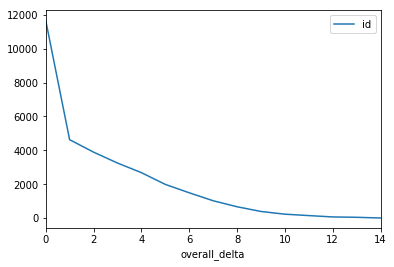

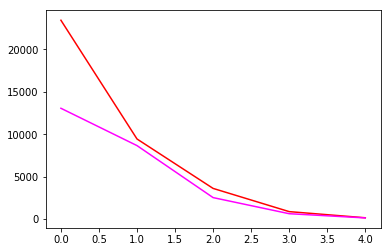

In [30]:
prd_delta = dau_pact_table[threshold:][dau_pact_table['is_active'] == 1]['prd_delta'].mean()
clf_delta = 1 - dau_pact_table['clf_acc'][threshold:].mean()
clf_e1 = dau_pact_table['clf_e1'][threshold:].mean()
clf_e2 = dau_pact_table['clf_e2'][threshold:].mean()
overall_delta = dau_pact_table['overall_delta'][threshold:].mean()
print('Среднее отклонение классификатора активности:', clf_delta)
print('Ошибка классификатора 1 рода (игрок на самом деле активен):', clf_e1)
print('Ошибка классификатора 2 рода (игрок на самом деле неактивен):', clf_e2)
print('Среднее отклонение предсказателя дней:', prd_delta)
print('Среднее общее отклонение:', overall_delta)
overall_delta_round = dau_pact_table['overall_delta'][threshold:].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
active_delta_round = dau_pact_table[threshold:][dau_pact_table['is_active'] == 1.0]['overall_delta'].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
overall_delta_round.plot()
categories_delta = [int(overall_delta_round[0:3].sum()), int(overall_delta_round[3:6].sum()), int(overall_delta_round[6:9].sum()), int(overall_delta_round[9:12].sum()), int(overall_delta_round[12:14].sum())]
active_categories_delta = [int(active_delta_round[0:3].sum()), int(active_delta_round[3:6].sum()), int(active_delta_round[6:9].sum()), int(active_delta_round[9:12].sum()), int(active_delta_round[12:14].sum())]
print(categories_delta)
print(active_categories_delta)
plt.show()
plt.plot(categories_delta, color='red')
plt.plot(active_categories_delta, color='magenta')
plt.show()

Важность свойств в порядке убывания важности:

In [18]:
w_features = copy.copy(clf_features)
for i in range(len(clf_features)):
    w_features[i] = (fitted_clf_gbr.feature_importances_[i], clf_features[i])
w_features = sorted(w_features)
for i in range(len(w_features) - 1, -1, -1):
    print(w_features[i])

(0.23769941830985253, 'w4_played')
(0.089632225326218173, 'pgr_w4_mean')
(0.052125226020822035, 'pgr_w3_mean')
(0.040299649094328691, 'pgr_w4_meandmax')
(0.04026067971290094, 'clusters_w4_mean')
(0.038587586253731869, 'pgr_w1_mean')
(0.035665331718670895, 'w3_played')
(0.032429119907272416, 'pgr_w2_meandmax')
(0.026437377455021015, 'quest_w4_mean')
(0.02485528045066265, 'clusters_w1_mean')
(0.02321740556170063, 'm_quests_w3_mean')
(0.02314472544648678, 'pgr_w1_meandmax')
(0.022365791336090027, 'pgr_w2_mean')
(0.022098356965981929, 'm_quests_w4_mean')
(0.019606217395505079, 'quest_w3_mean')
(0.018988944508413215, 'quest_w2_mean')
(0.017003075967736543, 'quest_w4_meandmax')
(0.016898081875576697, 'pgr_w3_meandmax')
(0.016546540241865457, 'clusters_w1_meandmax')
(0.016544437996199788, 'w2_played')
(0.01629721680822158, 'quest_w2_meandmax')
(0.015949399004019954, 'w1_played')
(0.014121850593207601, 'clusters_w3_mean')
(0.01314764778543767, 'clusters_w3_meandmax')
(0.012809666051830683, 'qu